In [1]:
import re
import os
import glob
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy import stats
import seaborn as sns
from tqdm import tqdm
import PyComplexHeatmap as pch
from PyComplexHeatmap import *
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [2]:
import joblib
mt_pelatte = joblib.load('/home/qzeng/project/aging/231117_update_annot/AgingMajorType_Palette')

new_mt_palette = {}
for mt ,_color in mt_pelatte.items():
    mt= mt.replace('/','').replace(' ','_')
    new_mt_palette[mt] = _color
   

In [3]:
use_stat = 'P-value'


In [4]:
#_ct = 'OPC_NN'
_type = 'Hyper'
known_motifs = glob.glob(f"re_condition_dmr/*/motif_*.{_type}//knownResults.txt")
len(known_motifs)

36

In [5]:
if _type == 'Hyper':
    p_value_cutoff = 1e-10
    min_fc = 1.1
    min_cts = 1
    use_motifs =3
    figsize = (4,6)
elif _type == 'Hypo':
    p_value_cutoff = 1e-30
    min_fc = 1.1
    min_cts = 3
    use_motifs =3
    figsize = (6,8)

In [6]:
motif_pvalue = defaultdict(dict)
motif_fc = defaultdict(dict)

for motif_result in known_motifs:
    result_df = pd.read_csv(motif_result, sep="\t", index_col=0)
    result_df.index = [x.split("/")[0] for x in result_df.index]

    cell_type =  motif_result.split('/')[-3]
    hyp = motif_result.split("/")[-2].split("_")[-1]
    
    for motif, row in result_df.iterrows():
        if row[use_stat] < p_value_cutoff:
            #fc = row.iloc[4]/row.iloc[6]
            fc = float(row.iloc[5].split('%')[0])/float(row.iloc[7].split('%')[0])
            motif_pvalue[motif][f'{cell_type}'] = row[use_stat]
            motif_fc[motif][f'{cell_type}'] = fc 

In [7]:
motif_pvalue_df = pd.DataFrame.from_dict(motif_pvalue, orient='index')
motif_fc_df = pd.DataFrame.from_dict(motif_fc, orient='index')
motif_pvalue_df.replace(0, 1.000000e-100, inplace=True)

In [8]:
## select use motifs and celltypes
select_cts = motif_pvalue_df < p_value_cutoff
select_cts = select_cts.sum(axis = 0) 
select_cts = select_cts[select_cts >= min_cts].index

select_motifs = motif_pvalue_df < p_value_cutoff
select_motifs = select_motifs.sum(axis = 1) 
select_motifs = select_motifs[select_motifs >= use_motifs].index

In [9]:
motif_pvalue_df = motif_pvalue_df.loc[select_motifs, select_cts]
motif_pvalue_df = -np.log10(motif_pvalue_df.sort_index(axis=1).sort_index()).fillna(0)
motif_pvalue_df.replace([np.inf, -np.inf], 0, inplace=True)
motif_pvalue_df  =motif_pvalue_df.fillna(0)

motif_fc_df = motif_fc_df.fillna(0)
motif_fc_df = motif_fc_df.loc[select_motifs, select_cts]

# if _type == 'Hypo':
#     motif_fc_df.drop(columns = ['Microglia_NN'], inplace = True)
#     motif_pvalue_df.drop(columns = ['Microglia_NN'], inplace = True)
# elif _type == 'Hyper':
#     motif_fc_df.drop(columns = ['Pvalb_Gaba'], inplace = True)
#     motif_pvalue_df.drop(columns = ['Pvalb_Gaba'], inplace = True)

In [10]:
motif_fc_df.index = [_index.split('(')[0] for _index in motif_fc_df.index]
#motif_fc_df.columns = [' '.join(_column.split('_')[:-1]) for _column in motif_fc_df.columns]

motif_pvalue_df.index = [_index.split('(')[0] for _index in motif_pvalue_df.index]
#motif_pvalue_df.columns = [' '.join(_column.split('_')[:-1]) for _column in motif_pvalue_df.columns]

In [11]:
col_annot = pd.DataFrame(motif_fc_df.columns, columns=['CellType'], index = motif_fc_df.columns)
col_annot.head()

,CellType
OPC_NN,OPC_NN
Astro-NT_NN,Astro-NT_NN
Oligo_NN,Oligo_NN
Astro-TE_NN,Astro-TE_NN
Pvalb_Gaba,Pvalb_Gaba


In [12]:
row_annot = pd.DataFrame(motif_fc_df.index, columns=['Motif'], index = motif_fc_df.index)
row_annot.head()

,Motif
Lhx2,Lhx2
Lhx1,Lhx1
LHX9,LHX9
En1,En1
DLX2,DLX2


In [13]:
def apply_custom_function(x):
    log_1e_100 = -np.log10(1e-100)
    log_1e_30 = -np.log10(1e-30)
    log_1e_5 = -np.log10(1e-5)
    
    if x >= log_1e_100:
        return '***'
    elif log_1e_100 > x >= log_1e_30:
        return '**'
    elif log_1e_30 > x >= log_1e_5:
        return '*'
    else:
        return ''

annot = motif_pvalue_df.applymap(apply_custom_function)

In [14]:
#z_scores_motif_fc_df = stats.zscore(motif_fc_df, axis = 0)

#log_df.fillna(0, inplace=True)
#log_df[log_df < 0] = 0

In [15]:
log_df = np.log2(motif_fc_df + 1e-5)

In [16]:
col_ha = pch.HeatmapAnnotation(label=pch.anno_label(col_annot.CellType, colors = 'black'),
                            MajorType=pch.anno_simple(col_annot.CellType,add_text=False,legend=False, colors = new_mt_palette, height = 3), axis=1,
                            legend=False,legend_gap=5,hgap=0.5, )

row_ha = pch.HeatmapAnnotation(label=pch.anno_label(row_annot.Motif, merge=True,rotation=0, colors = 'black' ),
                            #Motif=pch.anno_simple(row_annot.Motif,add_text=False,legend=False,height = 6), 
                               axis=0,
                           legend=False,legend_gap=5,hgap=0.5, label_kws=dict(visible=False))

Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations


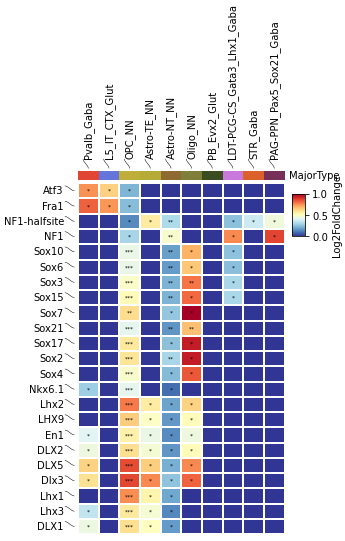

In [19]:
figsize = figsize
plt.figure(figsize=figsize)
top_annotation=col_ha,
cm = ClusterMapPlotter(
        data=log_df, 
        fmt=None,
        top_annotation=col_ha,
        left_annotation=row_ha,
        #show_rownames=True,
        annot=annot,annot_kws={'color':'black', 'size':6},
        #vmin = 0, vmax = 1.5,
        vmin = 0, vmax = 1,
        col_cluster=True,row_cluster=True,
        label = 'Log2FoldChange',z_score = None,
        tree_kws={'col_cmap': 'Set1'},verbose=0,legend_gap=7,
        linewidths=0.05,linecolor='white',cmap='RdYlBu_r',rasterized=True,
        xticklabels_kws={'labelrotation':0,'labelcolor':'blue'})
plt.savefig(f"figure/morecomplex.{_type}.logfc.PycomplexClustertmap.pdf", bbox_inches='tight')
plt.show()

In [18]:
# import PyComplexHeatmap as pch
# print(pch.__version__)